This will be an attempt to take what we have learned from the line attractor architecture, as well as redesigning the Baldassarre/Manella BG to try to have a more biologically realistic model of the BG perform SMS with the predicted tempo correction features. 

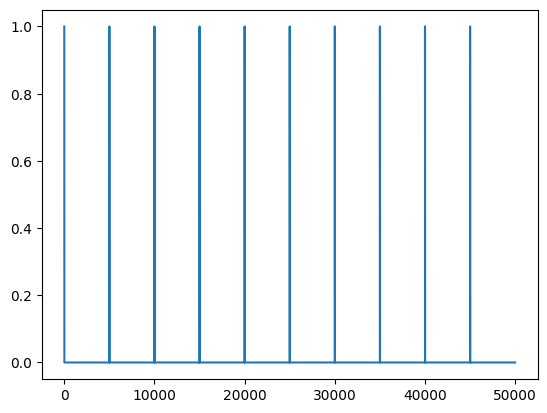

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#stable input of 500 ms period metronome
stable_input = np.zeros(5000 * 10)

for i in range(0,10):
    stable_input[i*5000] = 1

short_stable = np.zeros(5000 * 5)
for i in range(0,5):
    short_stable[i*5000] = 1

short_stable2 = np.zeros(5000 * 5)
for i in range(0,5):
    short_stable2[i*5100] = 1

thaut_test = np.concatenate((short_stable,short_stable2))


#lets just add twenty 510 ms stimuli onto the end of stable_input
thaut_fig4a = np.zeros(510 * 20)

for i in range(0,20):
    thaut_fig4a[i*510] = 1 

thaut_fig4a = np.concatenate((stable_input,thaut_fig4a))

#same thing for 550ms stimuli
thaut_fig2a = np.zeros(550*20)

for i in range(0,20):
    thaut_fig2a[i*550] = 1 

thaut_fig2a = np.concatenate((stable_input,thaut_fig2a))


plt.plot(stable_input)
#plt.plot(thaut_fig2a)

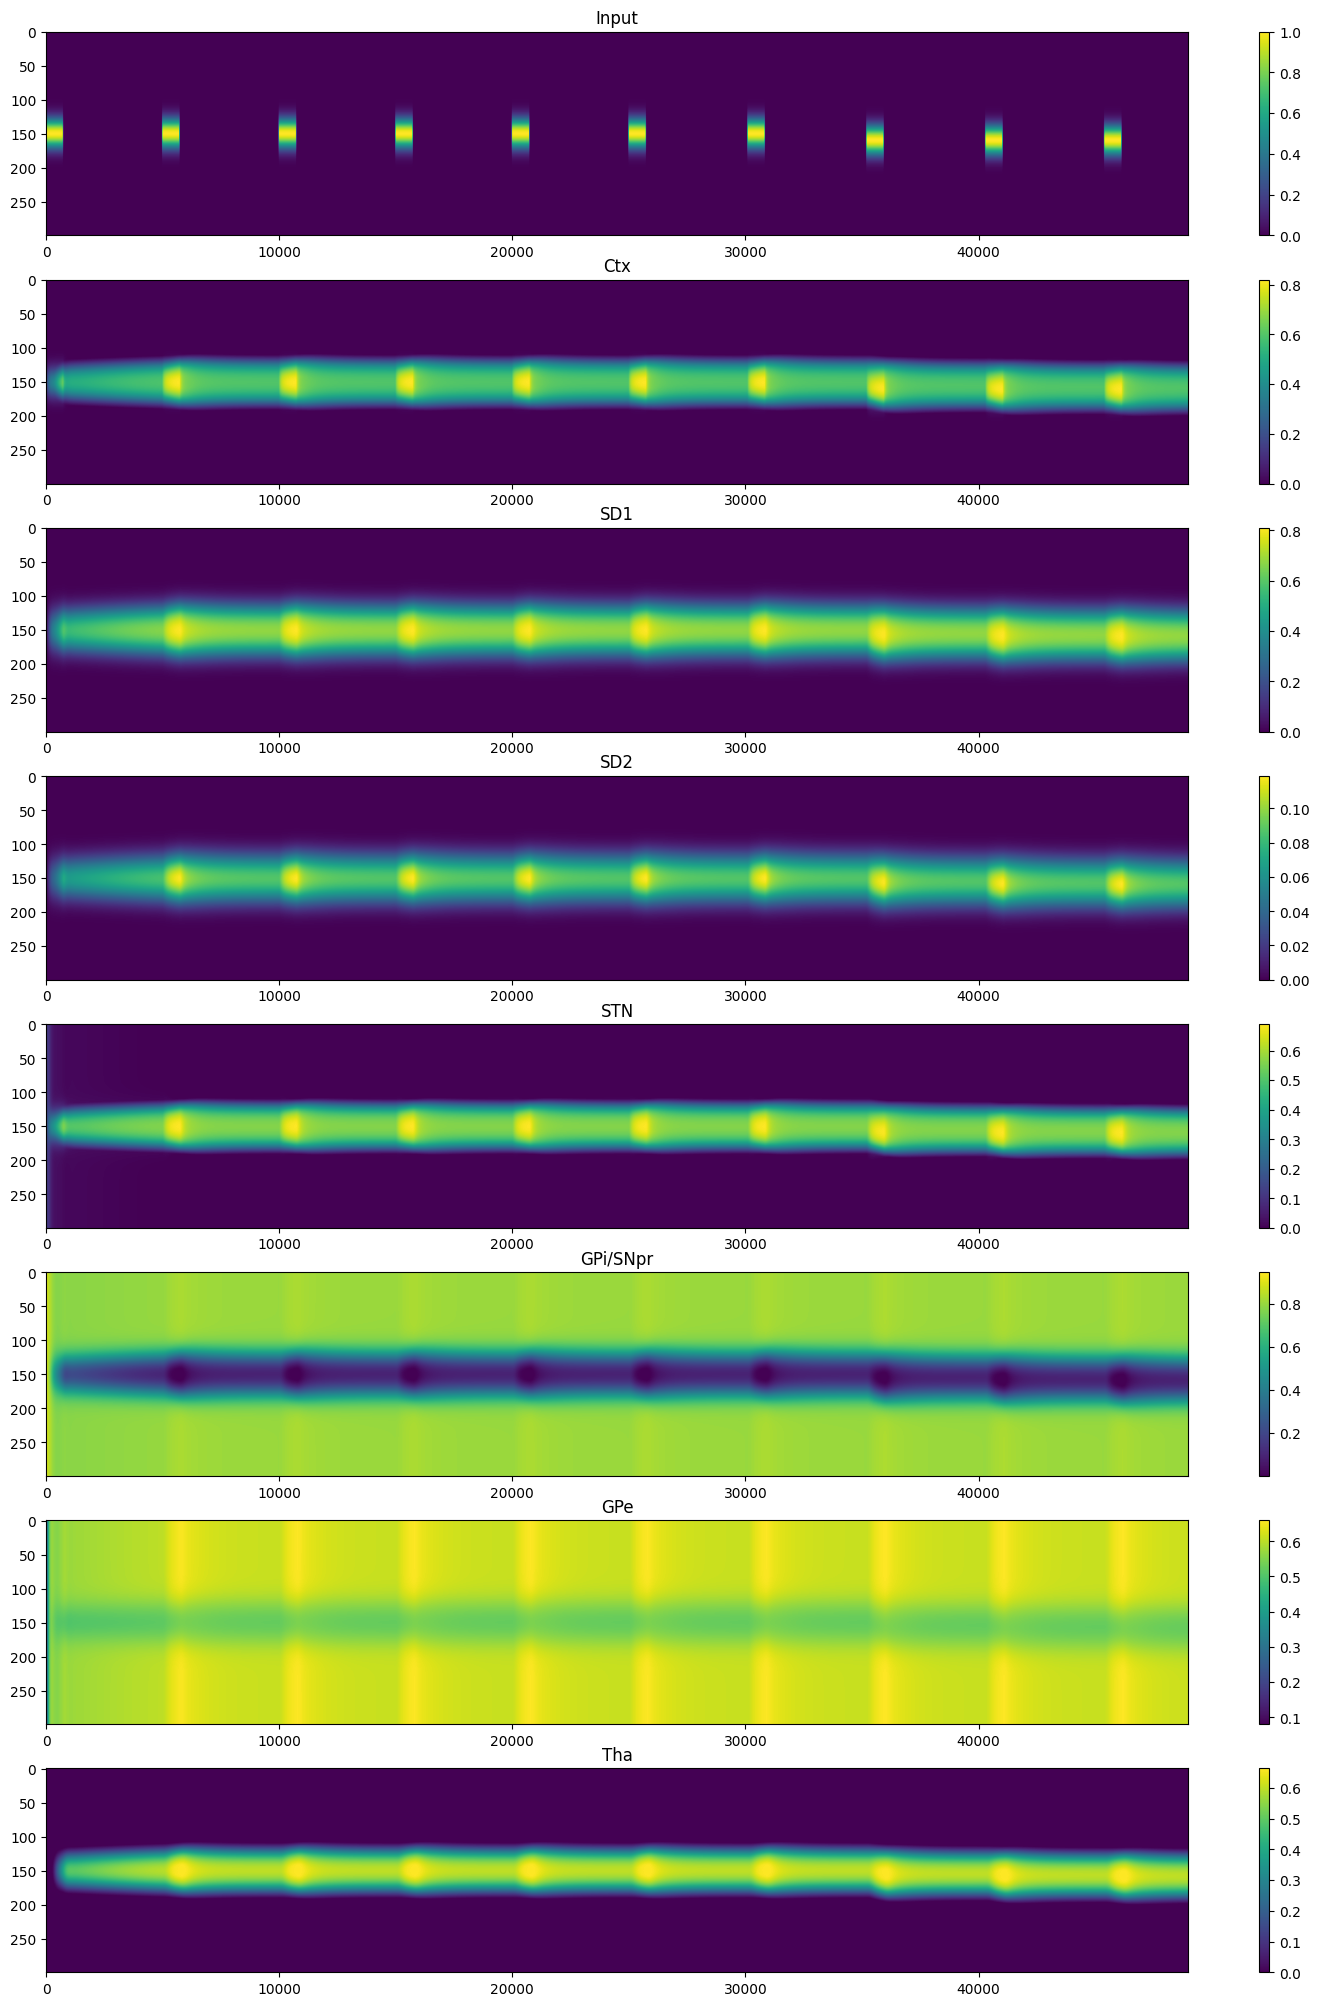

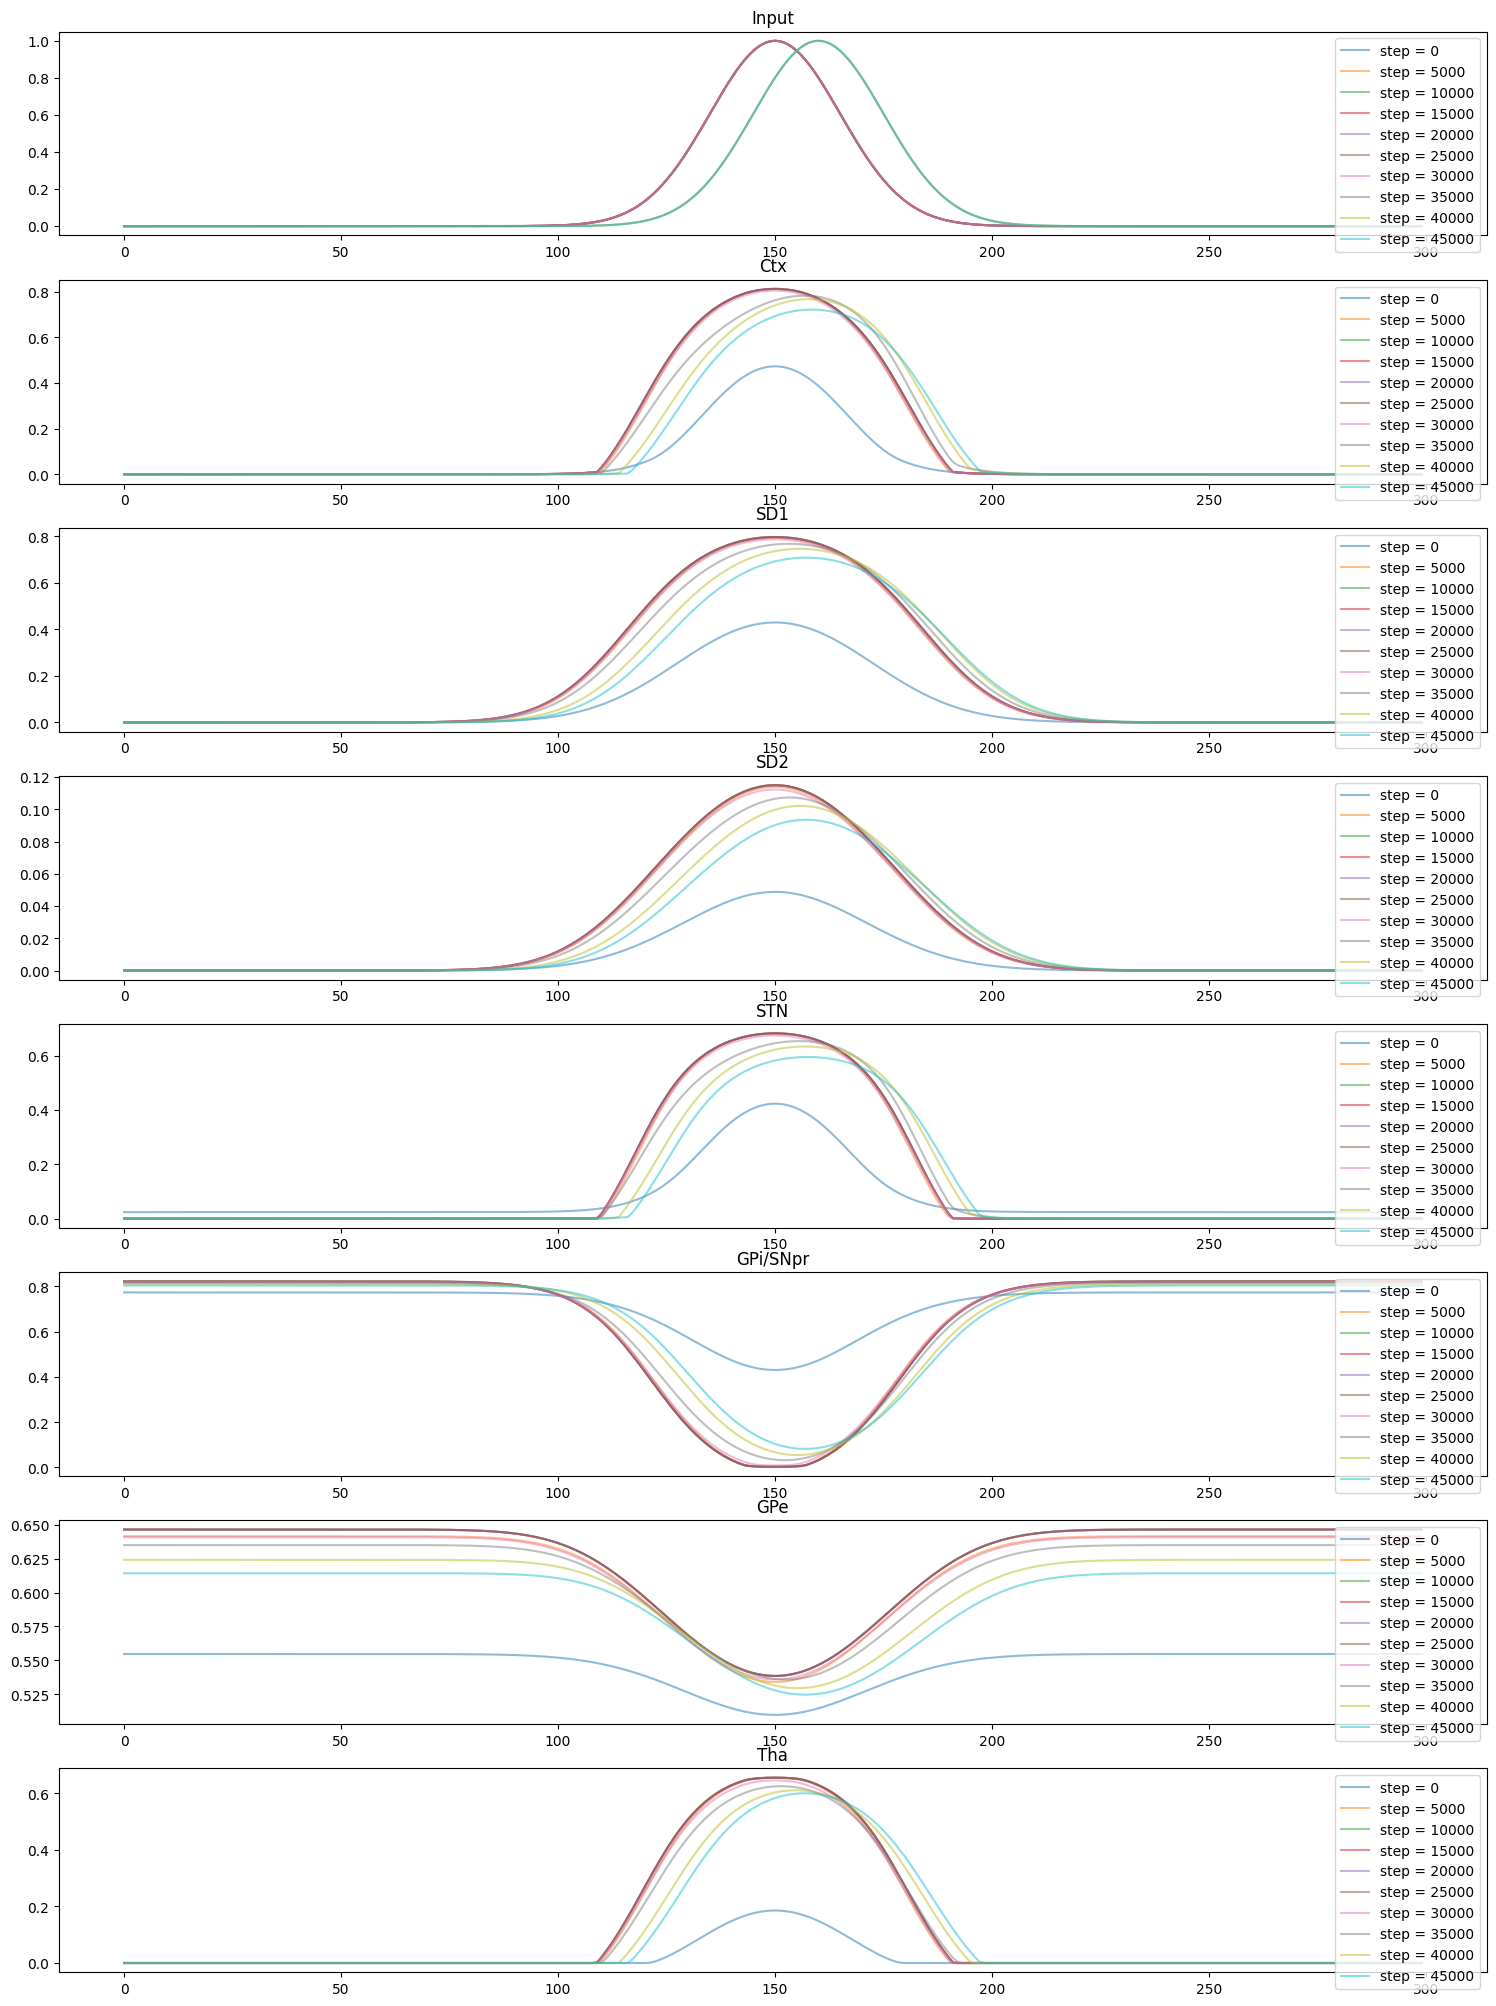

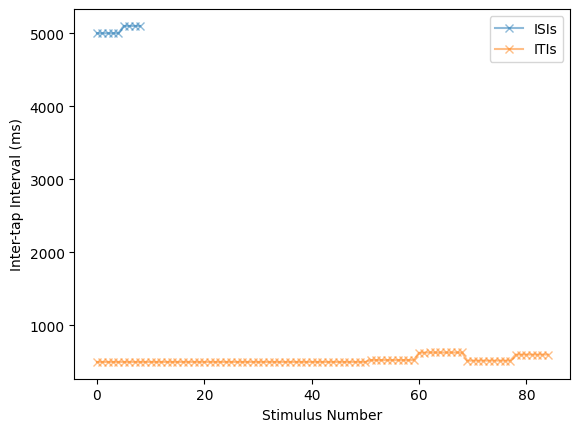

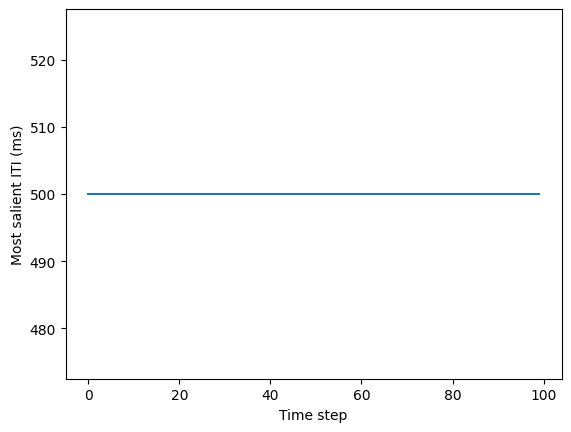

In [12]:
class b_ganglia:
    def __init__(self,n_loops,time_steps,exc_spread1):

        self.n_loops = n_loops
        self.n_steps = time_steps

        #activations for all units and matrix to hold input
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #vector to hold the inputs...
        self.a_input = np.zeros((time_steps, n_loops))


        #variable to keep track of what step we are currently on
        self.c = 0

        ####               weights connecting all the layers    #####

        #cortico-striatal connections are topographical, but also overlapping, thus we will use the Guassians we have previously shown work
        #first change from the original version, we will not have "input"-striatum connections, we will have a single cortical layer at the top receiving both "input" and thalamic input

        #initializing the matrices to hold all the weights
        self.w_ctx_sd1 = np.zeros((n_loops,n_loops))
        self.w_ctx_sd2 = np.zeros((n_loops,n_loops))


        #the weights from input to the cortex will just be the identity matrix I think
        self.w_inp_ctx = np.identity(n_loops) * 0.4 


        unit_ids = np.arange(0,n_loops,1)        
        for i in range(0,n_loops):
            #inserting the Guassians into the matrix
            #wider-spreading connectivities
            self.w_ctx_sd1[i] = stats.norm.pdf(unit_ids, i, exc_spread1) / np.max(stats.norm.pdf(unit_ids, i, exc_spread1)) * 0.04 #the dividing by the max ensure the weight distribution has a max of 1 before any other changes, just keeps the weights reasonable I think
            self.w_ctx_sd2[i] = stats.norm.pdf(unit_ids, i, exc_spread1) / np.max(stats.norm.pdf(unit_ids, i, exc_spread1)) * 0.04

        #second attempt at this, implementing pure 1-to-1 connectivity
        self.w_ctx_stn = np.identity(n_loops) * 1
        self.w_sd1_gpi = np.identity(n_loops) * -1.5
        self.w_sd2_gpe = np.identity(n_loops) * -1.5
        self.w_gpe_stn = np.identity(n_loops) * -0.5
        self.w_gpe_gpi = np.identity(n_loops) * -0.01
        self.w_gpi_tha = np.identity(n_loops) * -1.2
        self.w_tha_ctx = np.identity(n_loops) * 1.15

        #the STN has dense connectivity to the output nuclei so we can just set these as an array of ones
        self.w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 0.01
        self.w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0.01 



    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def run(self, stimulus, dopamine):

        #likely easier to just define the parameters inside this function...
        dt = 0.0001
        tau = 0.01
        #time constant 
        h= dt/tau
        unit_ids = np.arange(0,300,1) #this is used to define the input to the attractor later


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.6
        sd1_DA = 0.9
        sd2_bl = 1
        sd2_DA = 8

        #vector to hold whether or not a tap is produced each step...
        self.tapout = np.zeros(len(stimulus))
        self.tapout[5000] = 1

        #ISIs for the network
        self.stimulus = stimulus
        #dopamine throughout the simulation
        self.da = dopamine

        #start with the assumption the person already knows the ISI at start of simulation (all of our cases will start with 500 ms or 50 steps)
        isi = 500
        iti = 500
        #i think the input should also be dependent on the previous ISIs, you probably aren't 100% confident that a switch had been made
        #these are used to see if a tap and stimulus have arrived and need to be compared to eachother to make phase/tempo adjustments (nauseating code but what can you do)
        stim_here = 0
        tap_here = 0
        #this is even more gross, these are the indices at which the last tap or stimulus took place
        last_stim = 0
        last_tap = 100

        error = 0

        #eulers method
        for i in range(self.n_steps-600):

            if stimulus[i] == 1:
                #determining the input to the top of the network based on last observed ISI
                self.a_input[i:i+750] = stats.norm.pdf(unit_ids, isi - 350, 15) / np.max(stats.norm.pdf(unit_ids, isi - 350, 15))

            #vector containing abstract representation of activity in different cortical areas, receives user determined input, and connections from the thalamus
            self.a_ctx[i+1] = self.a_ctx[i] + h * (self.non_lin(np.matmul(self.a_input[i], self.w_inp_ctx) + np.matmul(self.a_tha[i], self.w_tha_ctx)) - self.a_ctx[i])
        
            #input to direct pathway of striatum, cortical input modulated by dopamine
            self.a_sd1[i+1] = self.a_sd1[i] + h * (self.non_lin((sd1_bl + sd1_DA * 0.5 * self.da[i]) * np.matmul(self.a_ctx[i], self.w_ctx_sd1)) - self.a_sd1[i])

            #input to sd2 modulated by dopamine
            self.a_sd2[i+1] = self.a_sd2[i] + h * (self.non_lin( (1/(sd2_bl + sd2_DA * self.da[i])) * np.matmul(self.a_ctx[i], self.w_ctx_sd2)) - self.a_sd2[i]) 

            #input to stn from ctx and gpe
            self.a_stn[i+1] = self.a_stn[i] + h * (self.non_lin(np.matmul(self.a_ctx[i], self.w_ctx_stn) + np.matmul(self.a_gpe[i], self.w_gpe_stn) + 0.3) - self.a_stn[i])

            #input to gpe from stn and sd2
            self.a_gpe[i+1] = self.a_gpe[i] + h * (self.non_lin(np.matmul(self.a_sd2[i], self.w_sd2_gpe) + np.matmul(self.a_stn[i], self.w_stn_gpe) + 0.4) - self.a_gpe[i])

            #input to gpi from strd1, stn, and gpe 
            self.a_gpi[i+1] = self.a_gpi[i] + h * (self.non_lin(np.matmul(self.a_sd1[i], self.w_sd1_gpi) + np.matmul(self.a_stn[i], self.w_stn_gpi) + np.matmul(self.a_gpe[i], self.w_gpe_gpi) + 0.8) - self.a_gpi[i])

            #input to thalamus from gpi 
            self.a_tha[i+1] = self.a_tha[i] + h * (self.non_lin(np.matmul(self.a_gpi[i], self.w_gpi_tha) + 0.8) - self.a_tha[i])

            if i>0: #probably easiest to have the stimulus always start on a tap, don't want this to cause errors tho
                if stimulus[i]==1:
                        #noting that there was a perceived stimulus
                        stim_here = 1
                        #reset perceived ISI based on most recent stimulus arrival

                        isi = (i - last_stim)/10
                        last_stim = i
            if self.tapout[i] == 1:
                    #noting that a tap has occured
                    tap_here = 1
                    last_tap = i
                    #if we have received stimuli from our own tap, note where the following tap would be, if phase adjustment does not occur
                    #calculate the current intertap interval from the bump attractor
                    iti = np.argmax(self.a_tha[i])+350 #uhhhhhhhhhhhhhh.....
                    #set the timing of the next tap, adjusted by any phase error from the last correction, also add some noise (literature suggests SD = 15 ms for ITI I think)
                    next_tap = int(i+iti) - int(error/4) #+ int(np.random.normal(0,10))
                    self.tapout[next_tap] = 1
                    

            
            #if there is both a tap and stimulus awaiting error assesment we can now make a phase correction
            if tap_here + stim_here == 2:
                error = last_tap - last_stim #this represents how far apart the last tap and last stimulus were

                #now we are waiting for the next set of taps and stimuli
                stim_here = 0
                tap_here = 0
        

        #calculating the ISIs and ITIs for the simulation        
        stim_indices = [i for i in range(len(stimulus)) if stimulus[i]==1]
        self.ISI_report = np.diff(stim_indices)
        #calculate the inter-tap intervals
        tap_indices = [i for i in range(len(self.tapout)) if self.tapout[i]==1]
        self.ITI_report = np.diff(tap_indices)

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(vec)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x



    def display(self):

        titles = ('Input','Ctx', 'SD1', 'SD2', "STN", "GPi/SNpr", "GPe", "Tha")
        data = (self.a_input,  self.a_ctx, self.a_sd1, self.a_sd2, self.a_stn, self.a_gpi, self.a_gpe, self.a_tha)

        fig, ax = plt.subplots(8)
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(8):
            im = ax[i].imshow(data[i][20:49000].T,aspect='auto')
            ax[i].set_title(titles[i])
            plt.colorbar(im, ax=ax[i])
        
        fig2, ax = plt.subplots(8)
        fig2.set_figheight(20)
        fig2.set_figwidth(15)
        fig2.tight_layout()

        for i in range(8):
            time_steps = np.arange(0,50000,5000)
            for step in time_steps:
                ax[i].plot(data[i][step + 500],alpha=0.5,label= str("step = "+str(step)))
                ax[i].set_title(titles[i])
                ax[i].legend()

        plt.figure(3)
        plt.plot(self.ISI_report, alpha=0.5, label="ISIs",marker='x')
        plt.plot(self.ITI_report, alpha=0.5, label="ITIs",marker="x")
        plt.xlabel('Stimulus Number')
        plt.ylabel('Inter-tap Interval (ms)')
        plt.legend()

        plt.figure(4)
        saliences = np.argmax(self.a_tha[5500:5600], axis=1) + 350
        plt.plot(saliences)
        plt.xlabel('Time step')
        plt.ylabel('Most salient ITI (ms)')
    
        plt.show

        return None

bg2 = b_ganglia(n_loops=300, time_steps=len(stable_input), exc_spread1=15)

dopamine = np.ones(len(stable_input))

bg2.run(thaut_test,dopamine)
bg2.display()
